# EEG Example (Parcel Level)

Start-to-end example script for applying the canonical HMM to EEG data. Note, because we source reconstruct, we need medium/high-density EEG: ~64+ channels.

In this example, we will use a standard brain in the source reconstruction, so only the EEG data is required.

#### Input Data

We will use data in BIDS format:
```
BIDS/
├── ...
├── sub-04/
│   ├── eeg/
│   │   ├── sub-04_task-rest_eeg.eeg
│   │   ├── sub-04_task-rest_eeg.vhdr
│   │   ├── sub-04_task-rest_eeg.vmrk
│   │   ├── sub-04_task-rest_loc.mat
│   │   ├── ...
├── ...
```
And write output to the `BIDS/derivatives` directory.

#### Steps

1. Preprocessing:
    - We clean the sensor-level EEG data and save the output to `BIDS/derivatives/preprocessed`.

2. Surface Extraction:
    - We use surfaces from a standard brain (MNI152) extracted with FSL.

3. Coregistration:
    - We will coregister the EEG electrodes with the structural MRI using Polhemus headshape points/fiducials and the surfaces from the MRI.
    - We will also compute the forward model.

4. Source Reconstruction (LCMV Beamformer):
    - We will compute a volumetric LCMV beamformer and apply it to the cleaned sensor data to get data in a voxel grid.

5. Parcellation:
    - We will parcel the data and orthogonalise to remove spatial leakage.
    - The output of steps 2-5 will be saved to `BIDS/derivatives/osl`.

6. Prepare Data for the Canonical HMM:
    - We will perform dipole sign flipping, time-delay embedding, PCA and standardisation to prepare the parcel data for the canonical HMM.

7. Fit the Canonical HMM:
    - We will apply the canonical HMM to the prepared data.

8. HMM Post-Hoc Analysis:
    - Estimate state-specific quantities of interest, such as spectral properties, networks, and summary statistics for dynamics.
    - The output will be saved to `BIDS/derivatives/hmm`.

 Although we provide a single start-to-end example script, it is possible to separate the different steps. E.g. you may wish to do all the preprocessing (for different sessions) in a script then have a separate script for the coregistration, source reconstruction and parcellation, as well as a different script for the HMM.

#### Import Packages

In [1]:
import os
import numpy as np
from scipy import io
from pathlib import Path

import mne
mne.viz.set_3d_backend("notebook")

from modules import preproc, rhino, source_recon, parcellation, hmm, utils

from osl_dynamics import inference, analysis
from osl_dynamics.utils import plotting
from osl_dynamics.data import Data

Using notebook 3d backend.


2026-01-19 18:58:43.665356: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Session Info

Let's specify which session in the `BIDS` directory we wish to study.

In [2]:
subject = "04"
task = "rest"
id = f"sub-{subject}_task-{task}"
print("id:", id)

id: sub-04_task-rest


## 1. Preprocessing

Now, we can clean the sensor data. We will use MNE to do this. Let's load the raw fif file.

In [3]:
raw_file = f"BIDS/sub-{subject}/eeg/{id}_eeg.vhdr"
raw = mne.io.read_raw_brainvision(raw_file, preload=True)

Extracting parameters from BIDS/sub-04/eeg/sub-04_task-rest_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 2741399  =      0.000 ...  1096.560 secs...


Now, let's perform some minimal preprocessing: filtering, downsampling and bad segment detection.

In [4]:
raw = raw.filter(l_freq=1, h_freq=45, method="iir", iir_params={"order": 5, "ftype": "butter"})
raw = raw.resample(sfreq=250)
raw = preproc.detect_bad_segments(raw, picks="eeg", significance_level=0.1)
raw = preproc.detect_bad_segments(raw, picks="eeg", mode="diff", significance_level=0.1)
raw = preproc.detect_bad_segments(raw, picks="eeg", metric="kurtosis", significance_level=0.1)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 1.00, 45.00 Hz: -6.02, -6.02 dB


Bad segment detection
---------------------
Modality: eeg
Mode: None
Metric: std
Significance level: 0.1
Maximum fraction: 0.1
Found 1 bad segments: 2.0/1096.6 seconds rejected (0.2%)

Bad segment detection
---------------------
Omitting 500 of 274140 (0.18%) samples, retaining 273640 (99.82%) samples.
Modality: eeg
Mode: diff
Metric: std
Significance level: 0.1
Maximum fraction: 0.1
Found 0 bad segments: 0.0/1096.6 seconds rejected (0.0%)

Bad segment detection
---------------------
Omitting 500 of 274140 (0.18%) samples, retaining 273640 (99.82%) samples.
Modality: eeg
Mode: None
Metric: kurtosis
Significance level: 0.1
Maximum fraction: 0.1
Found 3 bad segments: 6.0/1096.6 s

For EEG data, we need to add the sensor location information to the mne Raw object (needed for source reconstruction). There's no standardised way people save this information and you will likely need to write your own custom function specific to your dataset to add this information.

Note, if you do not have sensor locations, you could use a [standard montage](https://mne.tools/stable/auto_tutorials/intro/40_sensor_locations.html#sphx-glr-auto-tutorials-intro-40-sensor-locations-py).

In [5]:
def set_channel_montage(raw, localiser_file):
    X = io.loadmat(localiser_file, simplify_cells=True)
    ch_pos = {}
    for i in range(len(X["Channel"]) - 1):  # final channel is reference
        key = X["Channel"][i]["Name"].split("_")[2]
        if key[:2] == "FP":
            key = "Fp" + key[2]
        value = X["Channel"][i]["Loc"]
        ch_pos[key] = value
    hp = X["HeadPoints"]["Loc"]
    nas = np.mean([hp[:, 0], hp[:, 3]], axis=0)
    lpa = np.mean([hp[:, 1], hp[:, 4]], axis=0)
    rpa = np.mean([hp[:, 2], hp[:, 5]], axis=0)
    dig = mne.channels.make_dig_montage(ch_pos=ch_pos, nasion=nas, lpa=lpa, rpa=rpa)
    return raw.set_montage(dig)

raw = set_channel_montage(
    raw,
    localiser_file=f"BIDS/sub-{subject}/eeg/{id}_loc.mat",
)

Finally, we drop the EOG channel, apply an average re-referencing (needed for source reconstruction) and we save the preprocessed data.

In [6]:
raw = raw.drop_channels(["VEOG"])
raw = raw.set_eeg_reference(projection=True)

preproc_file = Path(f"BIDS/derivatives/preprocessed/{id}_preproc-raw.fif")
preproc_file.parent.mkdir(parents=True, exist_ok=True)
raw.save(preproc_file, overwrite=True)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Overwriting existing file.
Writing /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/preprocessed/sub-04_task-rest_preproc-raw.fif
Overwriting existing file.
Closing /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/preprocessed/sub-04_task-rest_preproc-raw.fif
[done]


[PosixPath('/Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/preprocessed/sub-04_task-rest_preproc-raw.fif')]

## 2. Surface Extraction

We need to extract surfaces (inskull, outskull and outskin) from a structural MRI before we can perform the coregistration. In this example we will use a standard brain. However, if you do have a structural you can extract the surfaces with:
```
rhino.extract_surfaces(
    mri_file=mri_file,
    outdir=f"BIDS/derivatives/anat_surfaces/sub-{subject}",
)
```

## OSL Output Files

Now we have the preprocessed sensor data and the MRI surfaces. We can perform an 'OSL' source reconstruction. This involves creating many files. Let's create an object (container) to keep track of all the files.

In [7]:
fns = utils.OSLFilenames(
    outdir="BIDS/derivatives/osl",
    id=id,
    preproc_file=f"BIDS/derivatives/preprocessed/{id}_preproc-raw.fif",
    surfaces_dir="mni152_surfaces",  # replace with the 'outdir' used in rhino.extract_surfaces if you have your own structural
)
print(fns)

OSLFilenames for sub-04_task-rest:
  Output directory:  BIDS/derivatives/osl
  Preprocessed file: BIDS/derivatives/preprocessed/sub-04_task-rest_preproc-raw.fif
  Surfaces directory: mni152_surfaces
  BEM directory:     BIDS/derivatives/osl/sub-04_task-rest/bem
  Coreg directory:   BIDS/derivatives/osl/sub-04_task-rest/coreg
    └─ Forward model: BIDS/derivatives/osl/sub-04_task-rest/coreg/model-fwd.fif
  Source directory:  BIDS/derivatives/osl/sub-04_task-rest/src
    └─ lcmv filters:  BIDS/derivatives/osl/sub-04_task-rest/src/filters-lcmv.h5


There are some files which we have already generated like the preprocessed fif file and the surfaces. Other files we will create in the following steps.

Now let's extract the Polhemus from the preprocessed fif file and coregister the MEG and MRI.

## 3. Coregistration

Next we use the Polhemus headshape points/fiducials to coregister the MEG and structural MRI.


Extracting fiducials/headshape points from fif info
---------------------------------------------------
    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
Saved: BIDS/derivatives/osl/sub-04_task-rest/coreg/head_nasion.txt
Saved: BIDS/derivatives/osl/sub-04_task-rest/coreg/head_rpa.txt
Saved: BIDS/derivatives/osl/sub-04_task-rest/coreg/head_lpa.txt
Saved: BIDS/derivatives/osl/sub-04_task-rest/coreg/head_headshape.txt

Running coregistration (HEAD (polhemus) -> MRI)
-----------------------------------------------
The MRI-derived nose is not going to be used to aid coregistration.
Please ensure that the headshape points do not include the nose
    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
Creating RawArray with float64 data, n_channels=61, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.
Overwriting existing file.
Writing /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/osl/sub-04_tas

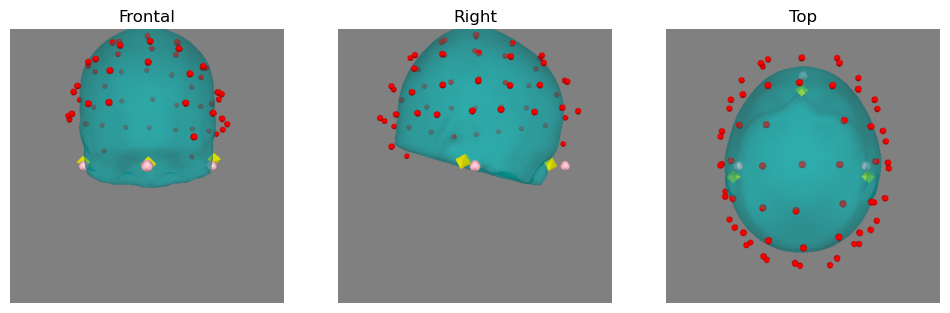

In [8]:
rhino.extract_fiducials_and_headshape_from_fif(fns, include_eeg_as_headshape=True)
rhino.coregister_head_and_mri(
    fns,
    use_nose=False,  # the standard brain (MNI152) doesn't include the nose
    allow_mri_scaling=True,  # set to False if using a real structural
)

Here, because we're using a standard brain, the EEG locations don't perfectly match the scalp. However, because we have real sensor locations, we'll leave them where they are.

Next, we calculate the forward model for MEG. Here, we're using a 'Triple Layer' head model and a dipole grid resolution of 8mm.

In [9]:
rhino.forward_model(fns, model="Triple Layer", gridstep=8, meg=False, eeg=True)


Calculating forward model
-------------------------
Using bet_inskull_surf_file for single shell surface
Surface CM = (   0.5  -18.8    5.6) mm
Surface fits inside a sphere with radius   88.3 mm
Surface extent:
    x =  -66.0 ...   67.7 mm
    y =  -99.6 ...   68.5 mm
    z =  -66.9 ...   79.8 mm
Grid extent:
    x =  -72.0 ...   72.0 mm
    y = -104.0 ...   72.0 mm
    z =  -72.0 ...   80.0 mm
8740 sources before omitting any.
5392 sources after omitting infeasible sources not within 0.0 - 88.3 mm.
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    4.0 mm away (will take a few...)
Checking surface interior status for 5392 points...
    Found  701/5392 points inside  an interior sphere of radius   44.0 mm
    Found    0/5392 points outside an exterior sphere of radius   88.3 mm
    Found 2139/4691 points outside using surface Qhull
    Found  190/2552 points outside using solid angles
    Total 3063/5392 points inside the surface
Int

## 4. Source Reconstruction

Now we are ready to create an LCMV beamformer. We will use a unit-noise-gain-invariant beamformer.

In [10]:
source_recon.lcmv_beamformer(fns, raw, chantypes="eeg", rank={"eeg": 50})


Making LCMV beamformer
----------------------
Reading forward solution from /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/osl/sub-04_task-rest/coreg/model-fwd.fif...
    Reading a source space...
    [done]
    1 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read EEG forward solution (2619 sources, 61 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Using up to 5482 segments
Number of samples used : 272100
[done]
Variance for chantype eeg is 1.5177894107214258e-10
Computing rank from covariance with rank={'eeg': 50}
Computing rank from covariance with rank='info'
    EEG: rank 60 after 1 projector applied to 61 channels
Making LCMV beamformer with data cov rank {'eeg': 50}
Making LCMV beamformer with noise cov rank {'eeg': 60}
Computing inverse operator with 61 channels.
    61 out of 61 channels remain after picking
Selected 61 channels
Whitening the forwar

Next, we calculate voxel data by applying the beamformer weights to the sensor data. Note, the following function returns the voxel data  (and coordinates) in MNI space.

In [11]:
voxel_data, voxel_coords = source_recon.apply_lcmv_beamformer(fns, raw)


Applying LCMV beamformer
------------------------
Omitting 2000 of 274140 (0.73%) samples, retaining 272140 (99.27%) samples.
Reading forward solution from /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/osl/sub-04_task-rest/coreg/model-fwd.fif...
    Reading a source space...
    [done]
    1 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read EEG forward solution (2619 sources, 61 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
spatial_resolution = 8 mm
mask_file: BIDS/derivatives/osl/sub-04_task-rest/src/MNI152_T1_8mm_brain.nii.gz
Finding nearest neighbour in resampled MNI space
Applying LCMV beamformer complete.


## 5. Parcellation

Now we have the voxel data, we can parcellate.

In [12]:
parcellation_file = "atlas-Giles_nparc-38_space-MNI_res-8x8x8.gz"

parcel_data = parcellation.parcellate(
    fns,
    voxel_data,
    voxel_coords,
    method="spatial_basis",
    orthogonalisation="symmetric",
    parcellation_file=parcellation_file,
)

parc_fif = f"BIDS/derivatives/osl/{id}/lcmv-parc-raw.fif"
parcellation.save_as_fif(
    parcel_data,
    raw,
    extra_chans="stim",
    filename=parc_fif,
)


Parcellating data
-----------------
gridstep = 8 mm


Resampled parcellation: BIDS/derivatives/osl/sub-04_task-rest/src/atlas-Giles_nparc-38_space-MNI_res-8x8x8.nii.gz
Finding nearest neighbour voxel
Calculating parcel time courses with spatial_basis
Performing symmetric orthogonalisation
Saving BIDS/derivatives/osl/sub-04_task-rest/lcmv-parc-raw.fif
Omitting 2000 of 274140 (0.73%) samples, retaining 272140 (99.27%) samples.
Creating RawArray with float64 data, n_channels=38, n_times=274140
    Range : 0 ... 274139 =      0.000 ...  1096.556 secs
Ready.
No stim channel to add to parc-raw.fif
Writing /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/osl/sub-04_task-rest/lcmv-parc-raw.fif
Closing /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/osl/sub-04_task-rest/lcmv-parc-raw.fif
[done]


The final data is saved in the file `lcmv-parc-raw.fif`. The parcellated data is saves as a `'misc'` channel type.

The last thing we will do is plot the PSD of the parcel data to check the source reconstruction looks reasonable.

Opening raw data file BIDS/derivatives/osl/sub-04_task-rest/lcmv-parc-raw.fif...
Isotrak not found
    Range : 0 ... 274139 =      0.000 ...  1096.556 secs
Ready.
Omitting 2000 of 274140 (0.73%) samples, retaining 272140 (99.27%) samples.


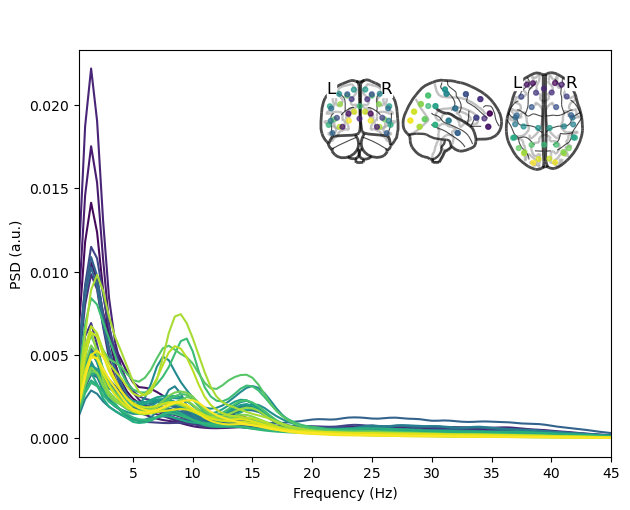

In [13]:
parcellation.plot_psds(parc_fif, parcellation_file=parcellation_file)

We should see alpha (~10 Hz) activity is posterior in the brain if not there may be an issue. Although note, there is a lot of subject variability, some subjects don't exhibit strong alpha oscillations.

## 6. Prepare Data for the Canonical HMM

Here, we prepare the data by aligning the sign of the parcel time courses to the template session from the canonical HMM and then perform time-delay embedding and PCA. Finally, we standardise the data. This is all done with the `prepare_data_for_canonical_hmm` function.

In [14]:
# Load and prepare the data
data = Data(parc_fif, picks="misc", reject_by_annotation="omit")
data = hmm.prepare_data_for_canonical_hmm(data, parcellation="38ROI_Giles")

# Save
hmm_dir = f"BIDS/derivatives/hmm/{id}"
data.save(hmm_dir)

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating covariances:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-19 19:23:12 INFO osl-dynamics [base.py:1175:align_channel_signs]: Aligning channel signs across sessions
2026-01-19 19:23:38 INFO osl-dynamics [base.py:1138:_find_and_apply_flips]: Session 0, Init 0, best correlation with template: 0.144
2026-01-19 19:23:59 INFO osl-dynamics [base.py:1138:_find_and_apply_flips]: Session 0, Init 1, best correlation with template: 0.146
2026-01-19 19:24:20 INFO osl-dynamics [base.py:1138:_find_and_apply_flips]: Session 0, Init 2, best correlation with template: 0.150


TDE-PCA:   0%|          | 0/1 [00:00<?, ?it/s]

Standardize:   0%|          | 0/1 [00:00<?, ?it/s]

Saving data:   0%|          | 0/1 [00:00<?, ?it/s]

## 7. Fit the Canonical HMM

First, we load a canonical HMM.

In [15]:
model = hmm.load_canonical_hmm(n_states=8, parcellation="38ROI_Giles")
model.summary()

Model: "HMM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 400, 80)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ means               │ (8, 80)           │        640 │ data[0][0]        │
│ (VectorsLayer)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ covs                │ (8, 80, 80)       │     25,920 │ data[0][0]        │
│ (CovarianceMatrice… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ll                  │ (None, 400, 80)   │          0 │ data[0][0],       │
│ (SeparateLogLikeli… │                   │            │ means[0][0],      │
│                     │                   │            │ covs[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hid_state_inf       │ [(None, 400, 80), │         72 │ ll[0][0]          │
│ (HiddenMarkovState… │ (None, 400, 8,    │            │                   │
│                     │ 8)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ll_loss             │ (1)               │          0 │ ll[0][0],         │
│ (SumLogLikelihoodL… │                   │            │ hid_state_inf[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,632 (104.03 KB)

 Trainable params: 25,992 (101.53 KB)

 Non-trainable params: 640 (2.50 KB)

Now let's infer the probability of each state being active at a given time point in the new data.

2026-01-19 19:24:29 INFO osl-dynamics [inf_mod_base.py:1151:get_alpha]: Getting alpha


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 490ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 480ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 473ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 467ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 458ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 466ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 493ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 465ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step  


2026-01-19 19:24:47.404113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Writing /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/hmm/sub-04_task-rest/alp_raw.fif
Closing /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/hmm/sub-04_task-rest/alp_raw.fif
[done]


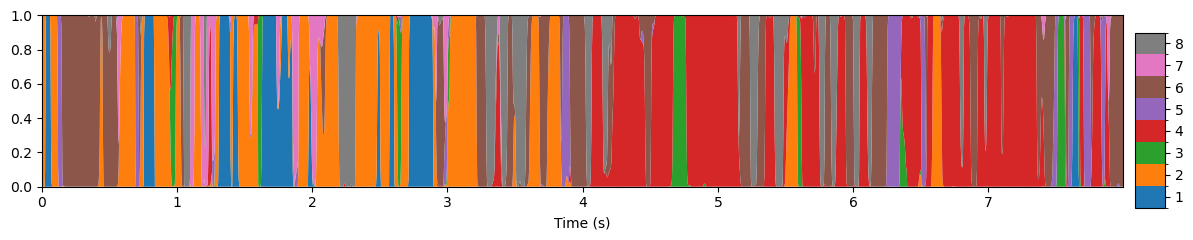

In [16]:
# State probability time course
alp = model.get_alpha(data)

# Save
alp_raw = inference.modes.convert_to_mne_raw(alp, parc_fif, n_embeddings=data.n_embeddings)
alp_raw.save(f"{hmm_dir}/alp_raw.fif", overwrite=True)

# Plot (just the first 8 seconds for visualisation)
fig, ax = plotting.plot_alpha(alp, n_samples=2000, sampling_frequency=250)

## 8. HMM Post-Hoc Analysis

Now we have the state probabilities, we can perform 'post-hoc analysis' where we estimate state-specific quantities of interest such as spectral properties, networks, and summary statistics for dynamics.

See the [osl-dynamics docs](https://osl-dynamics.readthedocs.io/en/latest/documentation.html) for further information and tutorials, as well as code for visualisations.

Let's start with the spectral properties.

In [17]:
# Calculate multitaper
trimmed_data = data.trim_time_series(sequence_length=model.config.sequence_length, prepared=False)
f, psd, coh = analysis.spectral.multitaper_spectra(
    data=trimmed_data,
    alpha=alp,
    sampling_frequency=250,
    frequency_range=[1, 40],
)
print(f.shape)
print(psd.shape)
print(coh.shape)

# Save
np.save(f"{hmm_dir}/f.npy", f)
np.save(f"{hmm_dir}/psd.npy", psd)
np.save(f"{hmm_dir}/coh.npy", coh)

2026-01-19 19:24:48 INFO osl-dynamics [spectral.py:478:multitaper_spectra]: Calculating spectra


(79,)
(8, 38, 79)
(8, 38, 38, 79)


Now let's use the spectra to calculate state-specific networks.

In [18]:
# Power maps
pow_maps = analysis.power.variance_from_spectra(f, psd)
print(pow_maps.shape)
np.save(f"{hmm_dir}/pow_maps.npy", pow_maps)

# Coherence networks
coh_nets = analysis.connectivity.mean_coherence_from_spectra(f, coh)
print(coh_nets.shape)
np.save(f"{hmm_dir}/coh_nets.npy", coh_nets)

(8, 38)
(8, 38, 38)


Finally, let's calculate summary statistics for dynamics.

In [19]:
# Binarise the state probabilities
stc = inference.modes.argmax_time_courses(alp)

# Summary statistics
fo = analysis.post_hoc.fractional_occupancies(stc)
lt = analysis.post_hoc.mean_lifetimes(stc, sampling_frequency=250)
intv = analysis.post_hoc.mean_intervals(stc, sampling_frequency=250)
sr = analysis.post_hoc.switching_rates(stc, sampling_frequency=250)

# Save
np.save(f"{hmm_dir}/fo.npy", fo)
np.save(f"{hmm_dir}/lt.npy", lt)
np.save(f"{hmm_dir}/intv.npy", intv)
np.save(f"{hmm_dir}/sr.npy", sr)